# Inferential Statistics

*Author: Evan Carey*

*Copyright 2017, BH Analytics, LLC*

## Overview

The purpose of this section is to demonstrate how to implement inferential statistics in Python. We will cover both continuous and discrete case variables.

## Libraries

In [1]:
## Import Modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.metrics import confusion_matrix
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

In [2]:
## Enable inline plotting for graphics
%matplotlib inline

In [3]:
## Get Version information
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("SciKitLearn version: {0}".format(sklearn.__version__))
print("Statsmodels version: {0}".format(statsmodels.__version__))

3.5.2 |Anaconda 4.3.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.19.2
Matplotlib version: 2.0.0
Numpy version: 1.11.3
SciKitLearn version: 0.18.1
Statsmodels version: 0.6.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
## Check/set your working directory
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
os.chdir(r"C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs")
print("My new working directory:\n" + os.getcwd())

My working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs\Intermediate_python\course_downloads\intermediate_course_download\notebooks
My new working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs


## Import the dataset

You should already have some experience with Pandas if you are taking this course. Below, I use Pandas to import a CSV file that we will use for a few examples. This is a dataset of low birthweights and various risk factors. 

In [5]:
#### Binary Outcomes
birthwt = pd.read_csv(r"data\birthwt.csv")
birthwt["low_cat"] = pd.Categorical.from_codes(birthwt.low,categories=["No","Yes"])
birthwt["smoke_cat"] = pd.Categorical.from_codes(birthwt.smoke,categories=["No","Yes"])
birthwt["race_cat"] = birthwt["race"].astype('category')

In [6]:
birthwt.head()

low  age  lwt  race  smoke  ptl  ht  ui  ftv   bwt low_cat smoke_cat  \
0    0   19  182     2      0    0   0   1    0  2523      No        No   
1    0   33  155     3      0    0   0   0    3  2551      No        No   
2    0   20  105     1      1    0   0   0    1  2557      No       Yes   
3    0   21  108     1      1    0   0   1    2  2594      No       Yes   
4    0   18  107     1      1    0   0   1    0  2600      No       Yes   

  race_cat  
0        2  
1        3  
2        1  
3        1  
4        1

In [7]:
birthwt.tail()

low  age  lwt  race  smoke  ptl  ht  ui  ftv   bwt low_cat smoke_cat  \
184    1   28   95     1      1    0   0   0    2  2466     Yes       Yes   
185    1   14  100     3      0    0   0   0    2  2495     Yes        No   
186    1   23   94     3      1    0   0   0    0  2495     Yes       Yes   
187    1   17  142     2      0    0   1   0    0  2495     Yes        No   
188    1   21  130     1      1    0   1   0    3  2495     Yes       Yes   

    race_cat  
184        1  
185        3  
186        3  
187        2  
188        1

## Describing Categories

The heart of categorical data analysis is frequency tables. How often do the levels of the values occur?

The value_counts() method accomplishes this in 1D

In [8]:
pd.concat([birthwt.low_cat.value_counts(),
          birthwt.low_cat.value_counts(normalize=True)], axis=1)

low_cat   low_cat
No       130  0.687831
Yes       59  0.312169

## 2D Freq Tables

Frequency tables using 2+ dimensions leverage the pd.crosstab() function.

You can normalize the tables and add margins. 

In [9]:
## Make 2d+ frequency tables
pd.crosstab(birthwt.smoke_cat,birthwt.low_cat)

low_cat    No  Yes
smoke_cat         
No         86   29
Yes        44   30

In [10]:
pd.crosstab(birthwt.smoke_cat,
            birthwt.low_cat,
           margins=True)

low_cat     No  Yes  All
smoke_cat               
No          86   29  115
Yes         44   30   74
All        130   59  189

In [11]:
pd.crosstab(birthwt.smoke_cat,birthwt.low_cat,
            normalize=0)

low_cat          No       Yes
smoke_cat                    
No         0.747826  0.252174
Yes        0.594595  0.405405

## Chi-Square Test

We use a Chi-Square test to formally check for independence amongst this 2x2 table. 

We use the scipy package for this.

In [12]:
## Chisquared test / Categorical Data Analysis
from scipy.stats import chi2_contingency

tbl1  = pd.crosstab(birthwt.smoke_cat,birthwt.low_cat)
chi2, p, ddof, expected = chi2_contingency(tbl1)
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print(msg.format(chi2, p, ddof))

Test Statistic: 4.235928545602459
p-value: 0.03957696932523243
Degrees of Freedom: 1



## Fisher Exact Test

If there is a small cell value, we must use the Fisher exact instead of the chi-square.

In [13]:
## Chisquared test / Categorical Data Analysis
from scipy.stats import fisher_exact

tbl1  = pd.crosstab(birthwt.smoke_cat,birthwt.low_cat)
oddsratio,p = fisher_exact(tbl1)
msg = "p-value: {}"
print(msg.format(p))

p-value: 0.03617649869118417


## Continuous Distributions

We will import a small file of traits of cars to examine statistical methods of inference for continuous variables. 


In [14]:
mtcars = pd.read_csv(r"data\mtcars.csv")
mtcars.head()

mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
0  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4     4
1  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4     4
2  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
3  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3     1
4  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3     2

## Focus on Miles per Gallon

How do we examine a continuous distribution? 
What might our 'target of inference' be here?

In [15]:
mtcars.describe()

mpg        cyl        disp          hp       drat         wt  \
count  32.000000  32.000000   32.000000   32.000000  32.000000  32.000000   
mean   20.090625   6.187500  230.721875  146.687500   3.596563   3.217250   
std     6.026948   1.785922  123.938694   68.562868   0.534679   0.978457   
min    10.400000   4.000000   71.100000   52.000000   2.760000   1.513000   
25%    15.425000   4.000000  120.825000   96.500000   3.080000   2.581250   
50%    19.200000   6.000000  196.300000  123.000000   3.695000   3.325000   
75%    22.800000   8.000000  326.000000  180.000000   3.920000   3.610000   
max    33.900000   8.000000  472.000000  335.000000   4.930000   5.424000   

            qsec         vs         am       gear     carb  
count  32.000000  32.000000  32.000000  32.000000  32.0000  
mean   17.848750   0.437500   0.406250   3.687500   2.8125  
std     1.786943   0.504016   0.498991   0.737804   1.6152  
min    14.500000   0.000000   0.000000   3.000000   1.0000  
25%    16.892500   0.000000   0.000000   3.000000   2.0000  
50%    17.710000   0.000000   0.000000   4.000000   2.0000  
75%    18.900000   1.000000   1.000000   4.000000   4.0000  
max    22.900000   1.000000   1.000000   5.000000   8.0000

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


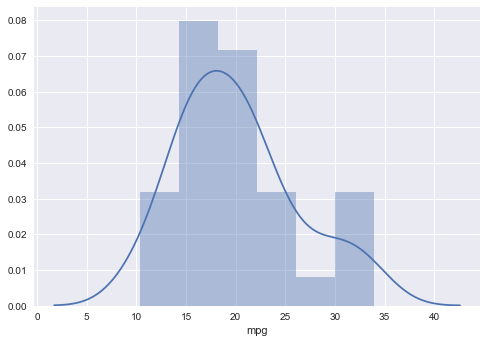

In [16]:
import seaborn as sns
sns.distplot(mtcars.mpg)

In [17]:
mtcars.mpg.mean()

20.090624999999996

In [18]:
mtcars.mpg.median()

19.2

In [19]:
mtcars.mpg.std()

6.026948052089105

In [20]:
mtcars.mpg.var()

36.32410282258065

## Comparing Distributions

* If we ask the question, do miles per gallon differ by transmission, what do we mean statistically by this? 
  
  
* To start answering this question, how would you describe the distribution of mpgs, independent of trans? (hint below)


In [21]:
mtcars.mpg.mean()

20.090624999999996

When we compare two distributions, we are really comparing the sample average distributions..
  
Then, what does it mean to conclude two distributions are different?
  
That means we believe their underlying population means are different!
  
“Sure they are different, but are they statistically significantly different? “


## Comparing Two Distributions

We can visually compare the two different distributions of data.
  
We might start to ask ourselves if they look that different…
  
Remember, the bigger the difference OR the more observations I have, the more certain I am of the result…

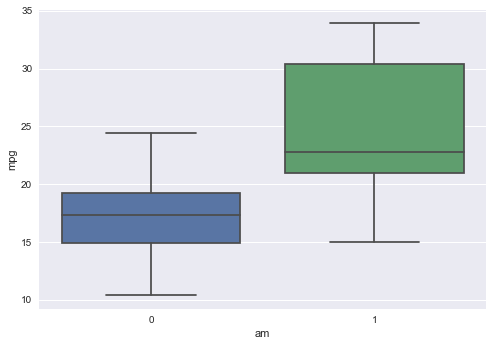

In [22]:
## Compare MPGs across groups
sns.boxplot(x="am", y="mpg",data=mtcars)

In [23]:
mtcars_group = mtcars.groupby(["am"])
mtcars_group.mpg.mean()

am
0    17.147368
1    24.392308
Name: mpg, dtype: float64

am
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: mpg, dtype: object

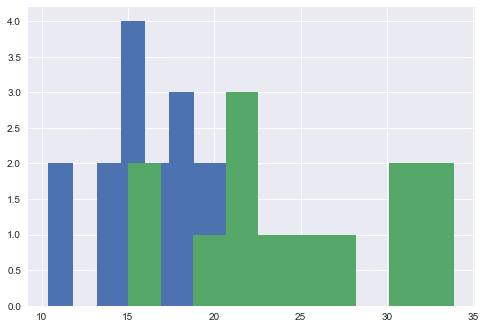

In [24]:
mtcars_group.mpg.hist()

am
0    Axes(0.125,0.125;0.775x0.755)
1    Axes(0.125,0.125;0.775x0.755)
Name: mpg, dtype: object

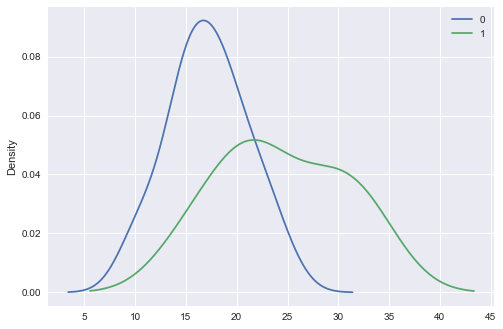

In [25]:
mtcars_group.mpg.plot(kind="kde",legend=True)

In [26]:
mtcars_group.mpg.agg([np.mean,np.std])

mean       std
am                     
0   17.147368  3.833966
1   24.392308  6.166504

## T-tests for statistical comparison

We use a t-test to do this comparison formally. 
  
What information do we need to know for the t-test?
  
Sample size, sample means, sample variance.


In [27]:
## Perform t-test
test_stat, p, df = \
    sm.stats.ttest_ind(mtcars.mpg[mtcars.am==0],
                       mtcars.mpg[mtcars.am==1])
msg = "Test Statistic: {}\nDegrees of Freedom: {}\np-value: {}\n"
print(msg.format(test_stat, df, p))

Test Statistic: -4.10612698310069
Degrees of Freedom: 30.0
p-value: 0.0002850207439350673



In [28]:
test_stat, p, df = \
    sm.stats.ttest_ind(mtcars.mpg[mtcars.am==0],
                       mtcars.mpg[mtcars.am==1],
                       usevar="unequal")
msg = "Test Statistic: {}\nDegrees of Freedom: {}\np-value: {}\n"
print(msg.format(test_stat, df, p))

Test Statistic: -3.7671231451449247
Degrees of Freedom: 18.332251638400464
p-value: 0.0013736383330710292



## Assumptions about Normality

The reason we can use this test is because we assume the sample mean is distributed normally. It is important to note that we do not make any assumptions about the actual data distribution here, we are only making assumptions about the distribution of the sample mean(s)!
  
We can do this because of something called the central limit theorum. 
  
This theorem says that no matter what the underlying distribution of some values are, if we take a sample and then calculate the sample average, the distribution of those sample averages will be normal if we have enough sample size (generally 40 or more).
  
How do we estimate the underlying population mean?
  
We calculate the sample average and the sample variance!

## Non-parametric group comparisons

If we are unable to assume normality, or if we are interested in making inference on something other than the mean, we may decide to use a non-parametric method to do the sample comparison.

One option would be the Kruskal-Wallis test, which is a test of population medians. 

In [29]:
from scipy.stats.mstats import kruskalwallis
test_stat, p = \
    kruskalwallis(mtcars.mpg[mtcars.am==0],
                  mtcars.mpg[mtcars.am==1])
msg = "Test Statistic: {}\np-value: {}\n"
print(msg.format(test_stat, p))

Test Statistic: 9.791362379012446
p-value: 0.0017533351106512793



## What about more than two?

What happens if there are more than two groups?

We now are asking the question, are these population means unequal? 

Is at least one of the group means not equal to the others?

## Visually Explore The Distributions

Does MPG differ by number of cylinders?

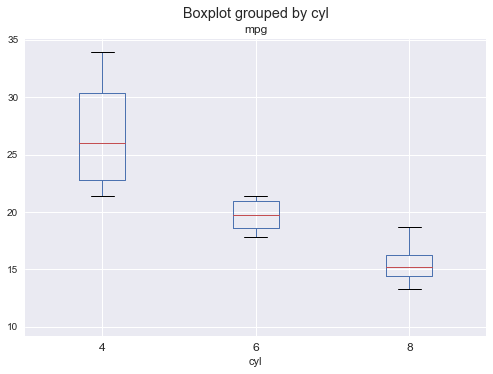

In [30]:
## mpg across cylinders
mtcars.boxplot("mpg",by="cyl")

cyl
4    Axes(0.125,0.125;0.775x0.755)
6    Axes(0.125,0.125;0.775x0.755)
8    Axes(0.125,0.125;0.775x0.755)
Name: mpg, dtype: object

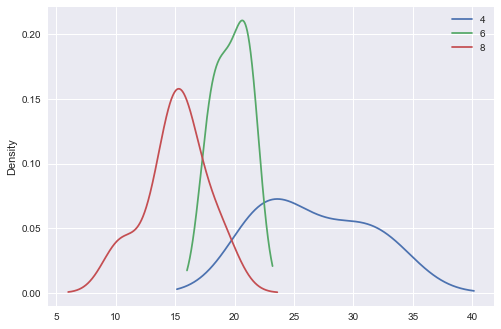

In [31]:
mtcars_group = mtcars.groupby(["cyl"])
mtcars_group.mpg.plot(kind="kde",legend=True)

In [32]:
mtcars_group.mpg.agg([np.mean,np.std])

mean       std
cyl                     
4    26.663636  4.509828
6    19.742857  1.453567
8    15.100000  2.560048

## ANOVA

The formal statistical test for this comparison is an ANOVA. This is an extension of a t-test. 

In [33]:
## perform anova
mtcars_lm1=smf.ols('mpg~C(cyl)', data=mtcars) #Specify C for Categorical
sm.stats.anova_lm(mtcars_lm1.fit(), typ=2)

sum_sq    df          F        PR(>F)
C(cyl)    824.784590   2.0  39.697515  4.978919e-09
Residual  301.262597  29.0        NaN           NaN

In [34]:
## get f statistic and p-value
sm.stats.anova_lm(mtcars_lm1.fit(), typ=2).ix[0,2:4]

F         3.969752e+01
PR(>F)    4.978919e-09
Name: C(cyl), dtype: float64

## Correlation

If we are interested in assessing the relationship between two continuous variables, we can use different forms of correlation. 

We typically summarize continuous by continuous relationships as correlation. 

Simply put, do these variables move together? Is there a relationship between them? 


C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


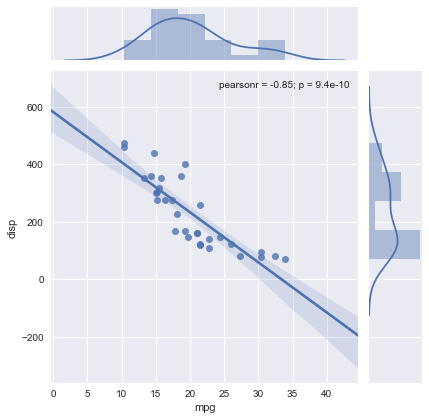

In [35]:
## Correlation
## seaborn image 
sns.jointplot(x="mpg", y="disp", data=mtcars, kind="reg")

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


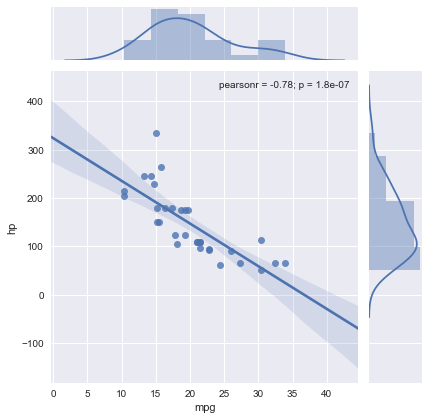

In [36]:
sns.jointplot(x="mpg", y="hp", data=mtcars, kind="reg")

## Calculating Correlation

We can calculate correlation as shown below.

Do you know the difference between Spearman and Pearson (the default)?

Pearson is the linear correlation, Spearman evaluates the monotonic relationship of the ranks.

We can use pandas to get a matrix of correlation values, however, we do not get the p-values. 

In [37]:
## Examine the linear correlation between mpg and other values
mtcars.loc[:,["mpg","disp","hp"]].corr()

mpg      disp        hp
mpg   1.000000 -0.847551 -0.776168
disp -0.847551  1.000000  0.790949
hp   -0.776168  0.790949  1.000000

In [38]:
mtcars.loc[:,["mpg","disp","hp"]].corr(method="spearman")

mpg      disp        hp
mpg   1.000000 -0.908882 -0.894665
disp -0.908882  1.000000  0.851043
hp   -0.894665  0.851043  1.000000

To get the p-values, we must use some other function. We can use scipy to do so. 

In [39]:
from scipy.stats import pearsonr
r, p = \
    pearsonr(mtcars.mpg,
             mtcars.disp)
msg = "Correlation: {}\np-value: {}\n"
print(msg.format(r, p))

Correlation: -0.8475513792624787
p-value: 9.38032653738138e-10



We can also get the spearman coefficient here.

In [40]:
from scipy.stats import spearmanr
r, p = \
    spearmanr(mtcars.mpg,
             mtcars.disp)
msg = "Correlation: {}\np-value: {}\n"
print(msg.format(r, p))

Correlation: -0.9088823637364655
p-value: 6.370336284303276e-13

